# Check GPU


In [1]:
!nvidia-smi


zsh:1: command not found: nvidia-smi


#Improved RoBERTa for PCL Detection with Enhanced Preprocessing and Hyperparameter Tuning


In [2]:
# Check GPU and install dependencies
!pip install simpletransformers tensorboardx nltk transformers tf-keras tensorflow



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import logging, random, pandas as pd, torch
from collections import Counter
from ast import literal_eval
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from urllib import request
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight



/Users/ginevracepparulo/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Term2/70016_NLP/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Set up logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print('Cuda available? ', cuda_available)

if cuda_available:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '/device:GPU:0':
        print('Found GPU at: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')


Cuda available?  False


In [6]:
# Fetch the Don't Patronize Me! data manager module
module_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name, 'w') as outf:
    outf.write(f.read().decode('utf-8'))


Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [8]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('../data/train/original_data', './data/train/original_data')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)


Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [9]:

# Load paragraph IDs for training and official dev set
trids = pd.read_csv('../data/train/sample_splits/train_semeval_parids-labels.csv')
teids = pd.read_csv('../data/train/sample_splits/dev_semeval_parids-labels.csv')
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)



In [10]:
data = dpm.train_task1_df

In [13]:

rows = []
for idx in range(len(trids)):
    parid = trids.par_id[idx]
    keyword = data.loc[data.par_id == parid].keyword.values[0]
    text = data.loc[data.par_id == parid].text.values[0]
    label = data.loc[data.par_id == parid].label.values[0]
    rows.append({
        'par_id': parid,
        'community': keyword,
        'text': text,
        'label': label
    })
trdf1 = pd.DataFrame(rows)


In [12]:

# Prepend the community label as an extra feature to the text

trdf1['text'] = trdf1['community'] + ": " + trdf1['text']

# Adjust class balance (for binary Task 1: treat label==1 as positive, label==0 as negative)
# Downsample negatives to get a ~1:3 ratio with the positive (PCL) class.
pcldf = trdf1[trdf1.label == 1]
npos = len(pcldf)
balanced_df = pd.concat([pcldf, trdf1[trdf1.label == 0][:npos * 3]])
balanced_df = shuffle(balanced_df, random_state=42)
print("Balanced training set shape:", balanced_df.shape)




Balanced training set shape: (3176, 4)


In [16]:
# Augmentation: Synonym Replacement (EDA)
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

def synonym_replacement(text, alpha=0.1):
    words = text.split()
    new_words = []
    for word in words:
        if random.uniform(0, 1) < alpha:
            synonyms = wordnet.synsets(word)
            if synonyms:
                lemmas = synonyms[0].lemma_names()
                if lemmas:
                    new_word = random.choice(lemmas)
                    new_words.append(new_word)
                else:
                    new_words.append(word)
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:

# Create augmented data by synonym replacement
augmented_rows = []
for idx, row in balanced_df.iterrows():
    new_text = synonym_replacement(row['text'], alpha=0.1)
    augmented_rows.append({
        'par_id': row['par_id'],
        'community': row['community'],
        'text': new_text,
        'label': row['label']
    })
augmented_df = pd.DataFrame(augmented_rows)
balanced_df = pd.concat([balanced_df, augmented_df])
balanced_df = shuffle(balanced_df, random_state=42)
print("After synonym augmentation:", balanced_df.shape)


After synonym augmentation: (6352, 4)


In [18]:
# Augmentation: Backtranslation (using MarianMT)
from transformers import pipeline
translator_en_to_de = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de")
translator_de_to_en = pipeline("translation_de_to_en", model="Helsinki-NLP/opus-mt-de-en")

def backtranslate(text):
    de_text = translator_en_to_de(text)[0]['translation_text']
    en_text = translator_de_to_en(de_text)[0]['translation_text']
    return en_text

# Augment a random 20% subset via backtranslation
bt_subset = balanced_df.sample(frac=0.2, random_state=42)
backtranslated_rows = []
for idx, row in bt_subset.iterrows():
    try:
        new_text = backtranslate(row['text'])
        backtranslated_rows.append({
            'par_id': row['par_id'],
            'community': row['community'],
            'text': new_text,
            'label': row['label']
        })
    except Exception as e:
        print("Backtranslation error:", e)
backtranslated_df = pd.DataFrame(backtranslated_rows)
balanced_df = pd.concat([balanced_df, backtranslated_df])
balanced_df = shuffle(balanced_df, random_state=42)
print("After backtranslation augmentation:", balanced_df.shape)


/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0
Device set to use cuda:0


After backtranslation augmentation: (7622, 4)


# Prepare Test Set for Task 1 (Official Dev Set)


In [14]:
# Rebuild dev set (Task 1) with extra feature
rows_test = []
for idx in range(len(teids)):
    parid = teids.par_id[idx]
    keyword = data.loc[data.par_id == parid].keyword.values[0]
    text = data.loc[data.par_id == parid].text.values[0]
    label = data.loc[data.par_id == parid].label.values[0]
    rows_test.append({
        'par_id': parid,
        'community': keyword,
        'text': text,
        'label': label
    })
tedf1 = pd.DataFrame(rows_test)

# Prepend community label to text in dev set as well
tedf1['text'] = tedf1['community'] + ": " + tedf1['text']


# Set Up Hyperparameters and Class Weights for the Model


In [20]:
import numpy as np

# Compute class weights for binary classification
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=balanced_df['label'])
class_weights = class_weights.tolist()
print("Class weights:", class_weights)



Class weights: [0.6649799336939453, 2.0153358011634057]


In [21]:
# Configure hyperparameters and early stopping options
task1_model_args = ClassificationArgs(
    num_train_epochs=3,
    learning_rate=2e-5,
    train_batch_size=16,
    evaluate_during_training=True,
    evaluate_during_training_steps=100,  # adjust as needed
    early_stopping_patience=2,
    early_stopping_delta=0.001,
    save_eval_checkpoints=True,
    save_model_every_epoch=True,
    overwrite_output_dir=True,
)
# Pass computed weights
task1_model_args.weight = class_weights


In [22]:
# Initialize the ClassificationModel with the improved hyperparameters
task1_model = ClassificationModel(
    "roberta",
    "roberta-base",
    args=task1_model_args,
    num_labels=2,
    use_cuda=cuda_available,
    weight=class_weights
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:

import tensorflow as tf

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)



In [24]:
task1_model.model.to(torch.device("cuda"))

for param in task1_model.model.parameters():
    print(param.device)  # Should print "cuda:0" for all parameters



cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0

In [25]:
# Train the model on the improved and augmented training set
# Split balanced_df into training and evaluation sets (80% train, 20% eval)
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Train the model with both training and evaluation data
task1_model.train_model(train_df[['text', 'label']], eval_df=eval_df[['text', 'label']])



/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 3:   0%|          | 0/382 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 3:   0%|          | 0/382 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 3:   0%|          | 0/382 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


(1146,
 defaultdict(list,
             {'global_step': [100,
               200,
               300,
               382,
               400,
               500,
               600,
               700,
               764,
               800,
               900,
               1000,
               1100,
               1146],
              'train_loss': [0.44013267755508423,
               0.5790743827819824,
               0.43697354197502136,
               0.280517578125,
               0.626390814781189,
               0.4246975779533386,
               0.8174444437026978,
               0.754889726638794,
               0.005973815452307463,
               0.007231642957776785,
               0.13442029058933258,
               0.049851760268211365,
               0.005881151184439659,
               0.0012607574462890625],
              'mcc': [0.5032687710829963,
               0.5630037587223254,
               0.6841028097542633,
               0.7317865086201228,
               

In [26]:
# Run predictions on the dev set (for evaluation)
preds_dev, _ = task1_model.predict(tedf1.text.tolist())
print("Dev set prediction counts:", Counter(preds_dev))

# Helper function to save predictions
def labels2file(p, outf_path):
    with open(outf_path, 'w') as outf:
        for pi in p:
            outf.write(','.join([str(k) for k in pi]) + '\n')

# Save dev set predictions as dev.txt
labels2file([[k] for k in preds_dev], 'dev.txt')



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Dev set prediction counts: Counter({0: 1818, 1: 276})


# Evaluation and Visualization on the Dev Set


Dev Set Accuracy: 0.9011461318051576
Dev Set Precision: 0.4855072463768116
Dev Set Recall: 0.6733668341708543
Dev Set F1 Score: 0.5642105263157895

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94      1895
           1       0.49      0.67      0.56       199

    accuracy                           0.90      2094
   macro avg       0.72      0.80      0.75      2094
weighted avg       0.92      0.90      0.91      2094



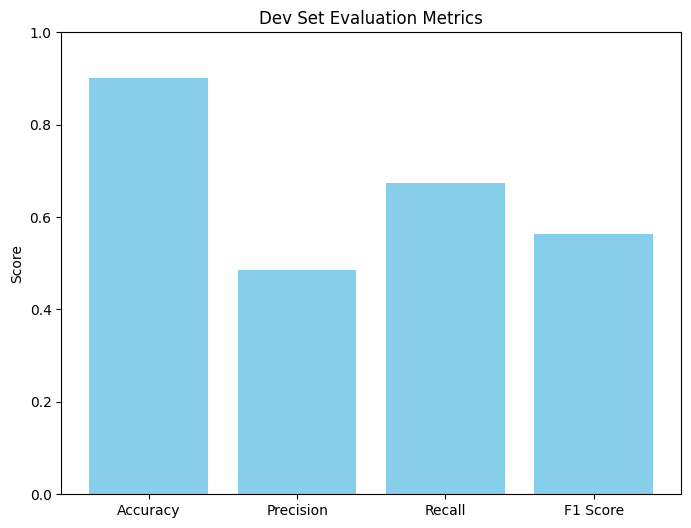

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# --- Compute Evaluation Metrics on the Dev Set ---
true_labels = tedf1['label'].tolist()
accuracy = accuracy_score(true_labels, preds_dev)
precision = precision_score(true_labels, preds_dev)
recall = recall_score(true_labels, preds_dev)
f1 = f1_score(true_labels, preds_dev)

print("Dev Set Accuracy:", accuracy)
print("Dev Set Precision:", precision)
print("Dev Set Recall:", recall)
print("Dev Set F1 Score:", f1)
print("\nClassification Report:\n", classification_report(true_labels, preds_dev))

# --- Plot Evaluation Metrics as a Bar Chart ---
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Dev Set Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

file_path = '../submission_improved/dev.txt'
# Open the file manually and read lines
file = open(file_path, "r")
lines = file.readlines()  # Reads all lines into a list
file.close()  # Don't forget to close the file!

# Process the lines into a list of integers
preds_dev_saved = [int(line.strip()) for line in lines]

true_labels = tedf1['label'].tolist()


0.9011461318051576

In [33]:
tedf1['pred'] = preds_dev_saved

In [38]:
tedf1['text_length'] = tedf1.text.apply(lambda x: len(x.split()))
tedf1

,par_id,community,text,label,pred,text_length
0,4046,hopeless,hopeless: We also know that they can benefit b...,1,0,86
1,1279,refugee,refugee: Pope Francis washed and kissed the fe...,1,1,39
2,8330,refugee,refugee: Many refugees do n't want to be reset...,1,0,17
3,4063,in-need,"in-need: ""Budding chefs , like """" Fred """" , """"...",1,1,43
4,4089,homeless,"homeless: ""In a 90-degree view of his constitu...",1,0,71
...,...,...,...,...,...,...
2089,10462,homeless,"homeless: The sad spectacle , which occurred o...",0,0,44
2090,10463,refugee,"refugee: """""" The Pakistani police came to our ...",0,0,38
2091,10464,disabled,"disabled: ""When Marie O'Donoghue went looking ...",0,0,39
2092,10465,women,"women: ""Sri Lankan norms and culture inhibit w...",0,0,65


In [ ]:
from IPython.display import display

# Choose any of the above filtering methods
mismatches = tedf1[tedf1['pred'] != tedf1["label"]]  # Boolean indexing

# Randomly sample 10 mismatched rows
sampled_mismatches = mismatches.sample(n=10, random_state=42)

display(sampled_mismatches[['text', 'label', 'pred']])


,text,label,pred
1433,in-need: That one person who always needs help...,0,1
37,immigrant: Many celebrities wore blue ribbons ...,1,0
346,migrant: Clans of various surnames and functio...,0,1
645,"poor-families: On the occasion , Major Fahad a...",0,1
1497,"poor-families: ""The living conditions of many ...",0,1
20,women: Maida noted that political issues shoul...,1,0
671,"in-need: """""" You also get to meet a lot of peo...",0,1
1138,immigrant: Pope hopes Trump re-thinks DACA dec...,0,1
50,"immigrant: ""Nearly 15,000 West African teenage...",1,0
1294,women: Women in Sri Lanka have proven their sk...,0,1


Mean text length for:
- False Negatives: 58.36923076923077
- False Positives: 53.190140845070424
- True Positives: 53.38805970149254
- True Negatives: 47.2749572162008


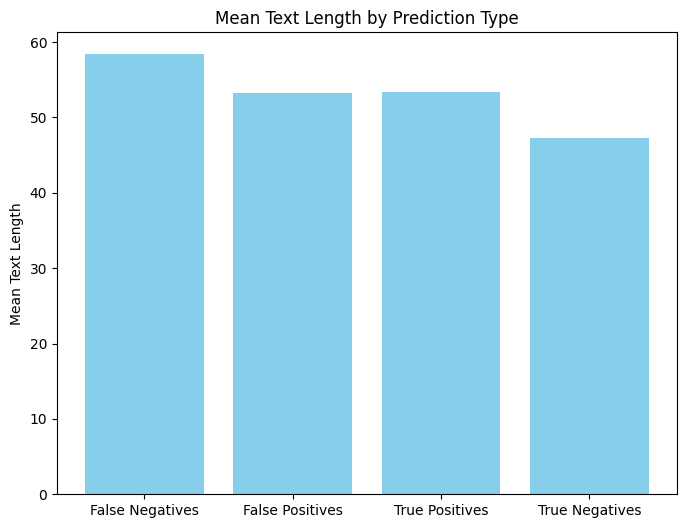

In [44]:
# False Negatives (label=1, pred=0)
fn_mean_length = tedf1.loc[(tedf1['label'] == 1) & (tedf1['pred'] == 0), 'text_length'].mean()

# False Positives (label=0, pred=1)
fp_mean_length = tedf1.loc[(tedf1['label'] == 0) & (tedf1['pred'] == 1), 'text_length'].mean()

# True Positives (label=1, pred=1)
tp_mean_length = tedf1.loc[(tedf1['label'] == 1) & (tedf1['pred'] == 1), 'text_length'].mean()

# True Negatives (label=0, pred=0)
tn_mean_length = tedf1.loc[(tedf1['label'] == 0) & (tedf1['pred'] == 0), 'text_length'].mean()

# Print results
print("Mean text length for:")
print(f"- False Negatives: {fn_mean_length}")
print(f"- False Positives: {fp_mean_length}")
print(f"- True Positives: {tp_mean_length}")
print(f"- True Negatives: {tn_mean_length}")
plt.figure(figsize=(8, 6))
plt.bar(['False Negatives', 'False Positives', 'True Positives', 'True Negatives'],
        [fn_mean_length, fp_mean_length, tp_mean_length, tn_mean_length],
        color='skyblue')
plt.title("Mean Text Length by Prediction Type")
plt.ylabel("Mean Text Length")
plt.savefig('../plots/mean_text_length.pdf')
plt.show()


In [58]:
import numpy as np

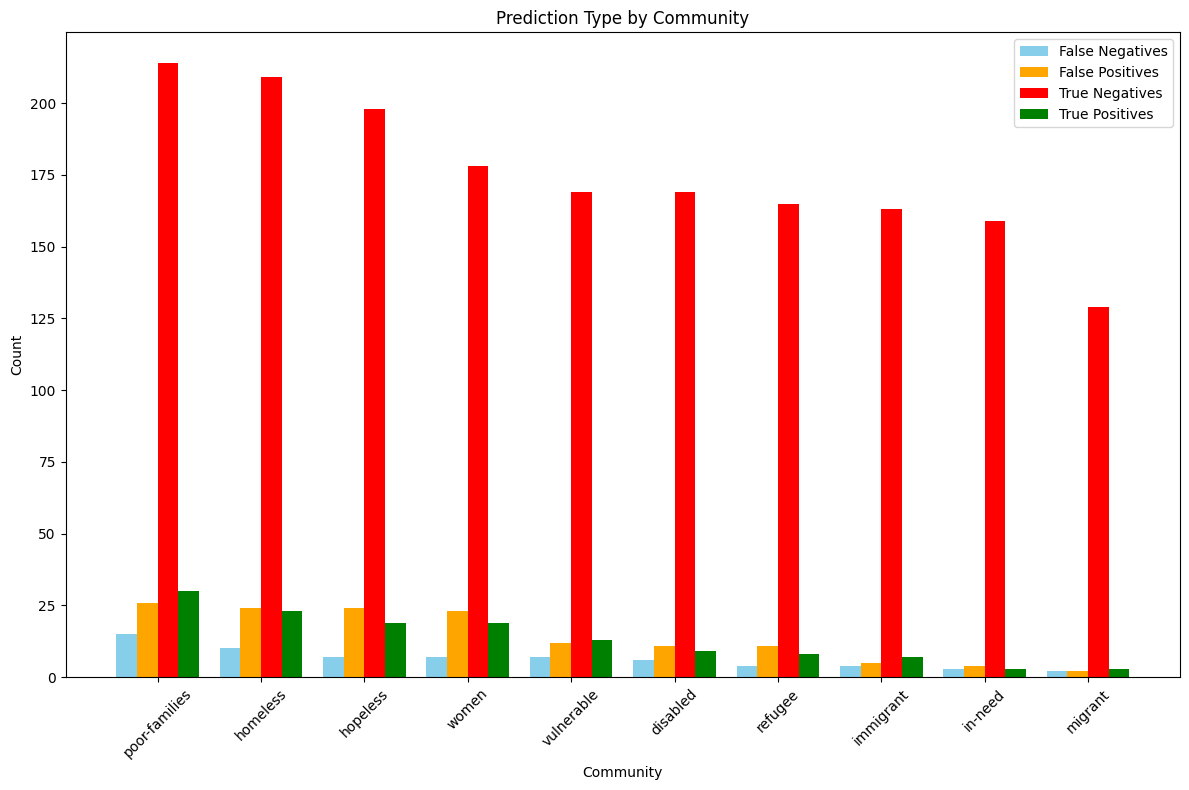

In [61]:
# False Negatives (label=1, pred=0)
fn_community = tedf1.loc[(tedf1['label'] == 1) & (tedf1['pred'] == 0), 'community'].value_counts()
fp_community = tedf1.loc[(tedf1['label'] == 0) & (tedf1['pred'] == 1), 'community'].value_counts()
tn_community = tedf1.loc[(tedf1['label'] == 0) & (tedf1['pred'] == 0), 'community'].value_counts()
tp_community = tedf1.loc[(tedf1['label'] == 1) & (tedf1['pred'] == 1), 'community'].value_counts()


x = np.arange(len(fn_community.index))  # X positions for bars
width = 0.2  # Width of bars

plt.figure(figsize=(12, 8))

plt.bar(x - width*1.5, fn_community.values, width, color='skyblue', label='False Negatives')
plt.bar(x - width/2, fp_community.values, width, color='orange', label='False Positives')
plt.bar(x + width/2, tn_community.values, width, color='red', label='True Negatives')
plt.bar(x + width*1.5, tp_community.values, width, color='green', label='True Positives')

# Formatting
plt.xticks(x, fn_community.index, rotation=45)  # Set labels at correct positions
plt.title("Prediction Type by Community")
plt.xlabel("Community")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig('../plots/prediction_type_by_community.pdf')
plt.show()


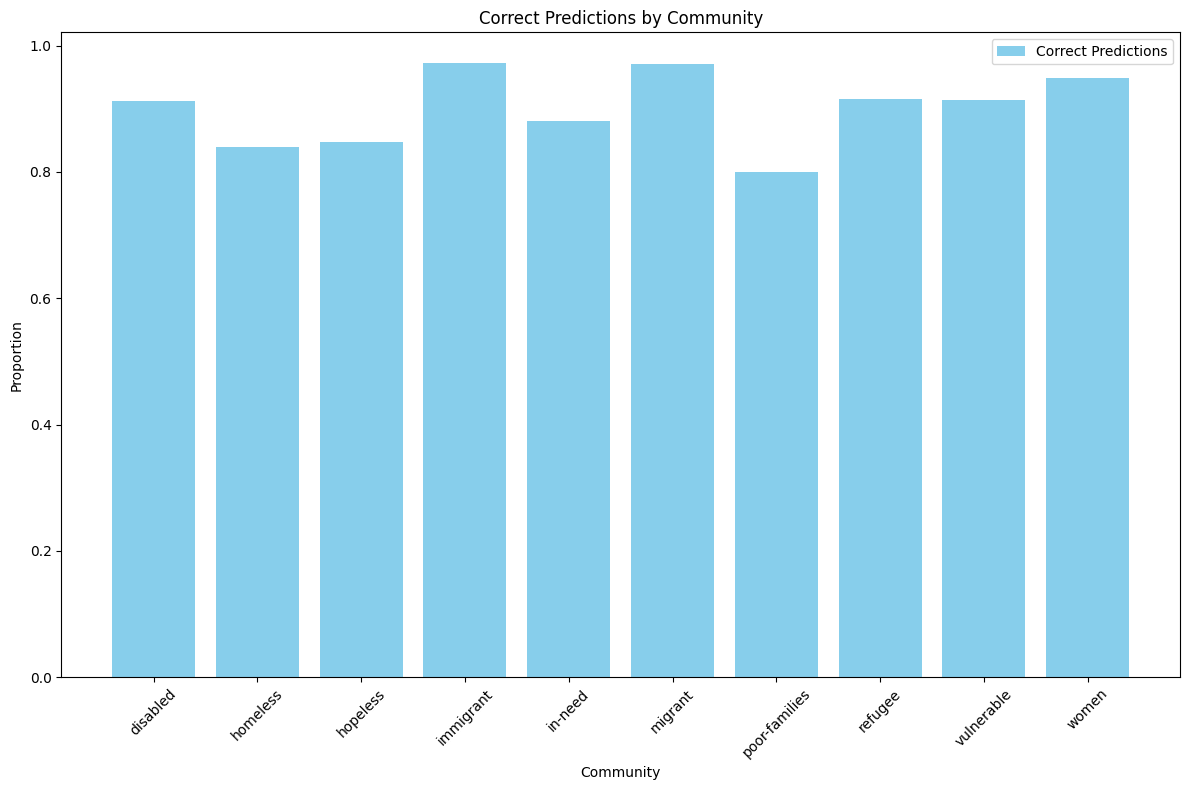

In [73]:
# False Negatives (label=1, pred=0)
#incorrect_community = tedf1.loc[(tedf1['label'] == 1) & (tedf1['pred'] == 0) | (tedf1['label'] == 0) & (tedf1['pred'] == 1), 'community'].value_counts() / tedf1['community'].value_counts()
correct_community = tedf1.loc[(tedf1['label'] == 0) & (tedf1['pred'] == 0) | (tedf1['label'] == 1) & (tedf1['pred'] == 1), 'community'].value_counts() / tedf1['community'].value_counts()

plt.figure(figsize=(12, 8))
x = np.arange(len(correct_community.index))  # X positions for bars
plt.bar(x, correct_community.values, color='skyblue', label='Correct Predictions')
# Formatting
plt.xticks(x, correct_community.index, rotation=45)  # Set labels at correct positions
plt.title("Correct Predictions by Community")
plt.xlabel("Community")
plt.ylabel("Proportion")
plt.legend()
plt.tight_layout()
#plt.savefig('../plots/correct_predictions_by_community.pdf')
plt.show()


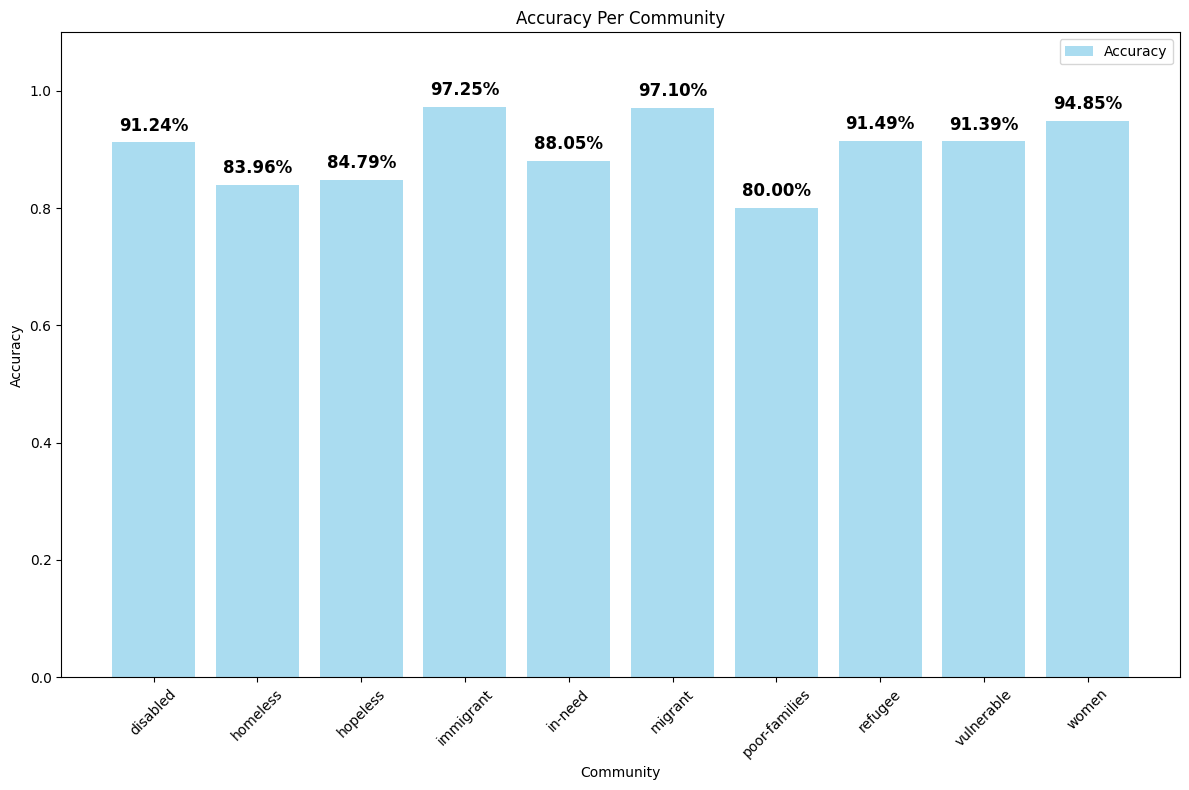

In [76]:
# Compute accuracy per community
accuracy_per_community = (tp_community + tn_community) / (tp_community + tn_community + fp_community + fn_community)

# Convert to NumPy array for plotting
x = np.arange(len(accuracy_per_community.index))  # X positions for bars
plt.figure(figsize=(12, 8))
# Plot accuracy bars
plt.bar(x, accuracy_per_community.values, color='skyblue', alpha=0.7, label='Accuracy')
# Add text labels above each bar
for i, acc in enumerate(accuracy_per_community.values):
    plt.text(x[i], acc + 0.02, f"{acc:.2%}", ha='center', fontsize=12, fontweight='bold')
# Formatting
plt.xticks(x, accuracy_per_community.index, rotation=45)  # Set labels at correct positions
plt.ylim(0, 1.1)  # Set y-axis limits (accuracy is between 0 and 1)
plt.title("Accuracy Per Community")
plt.xlabel("Community")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig('../plots/correct_predictions_by_community.pdf')
plt.show()


In [37]:
sampled_mismatches.to_json("../predictions/mismatched_predictions_roberta_improved.json", orient="records", lines=True)

# Load Official Test Set and Predict (Using task4_test.tsv)


In [ ]:
# Load the official test set (note: no labels available)
official_test_df = pd.read_csv('../data/test.tsv', sep='\t', header=None, names=['text'])
# If necessary, add any preprocessing (e.g., if extra features are needed, modify accordingly)

# Run predictions on the official test set
preds_test, _ = task1_model.predict(official_test_df['text'].tolist())
print("Official Test Prediction counts:", Counter(preds_test))

# Save official test set predictions as test.txt
labels2file([[k] for k in preds_test], 'test.txt')


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Official Test Prediction counts: Counter({0: 3373, 1: 459})


# Prepare Submission

In [29]:
!cat dev.txt | head -n 10
!cat test.txt | head -n 10
!zip submission_improved.zip dev.txt test.txt




0
1
0
1
0
0
1
1
0
1
0
0
0
0
0
0
1
0
0
0
  adding: dev.txt (deflated 94%)
  adding: test.txt (deflated 93%)
